[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.9.6. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

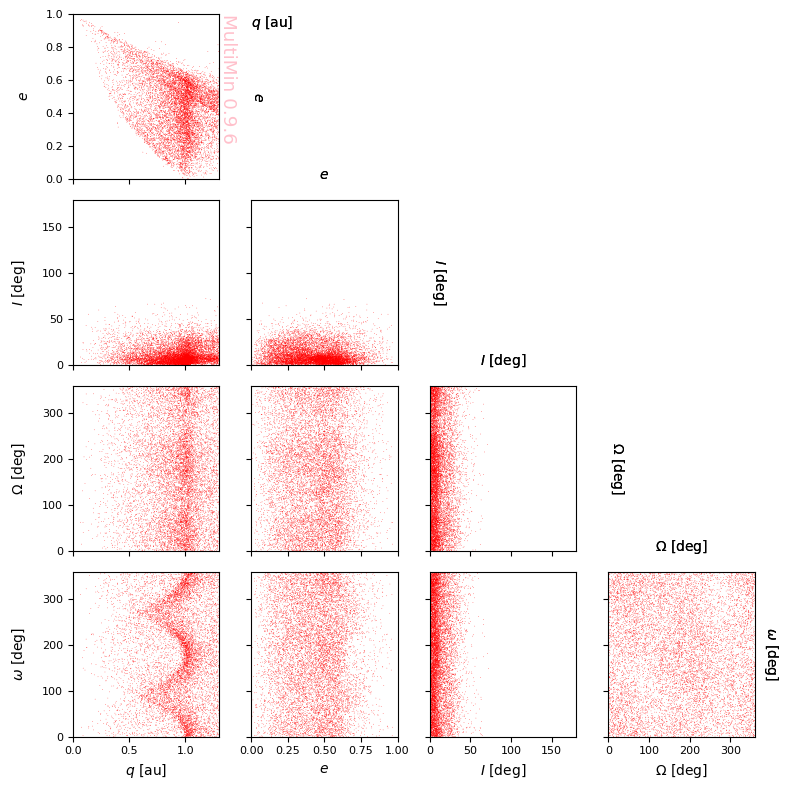

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

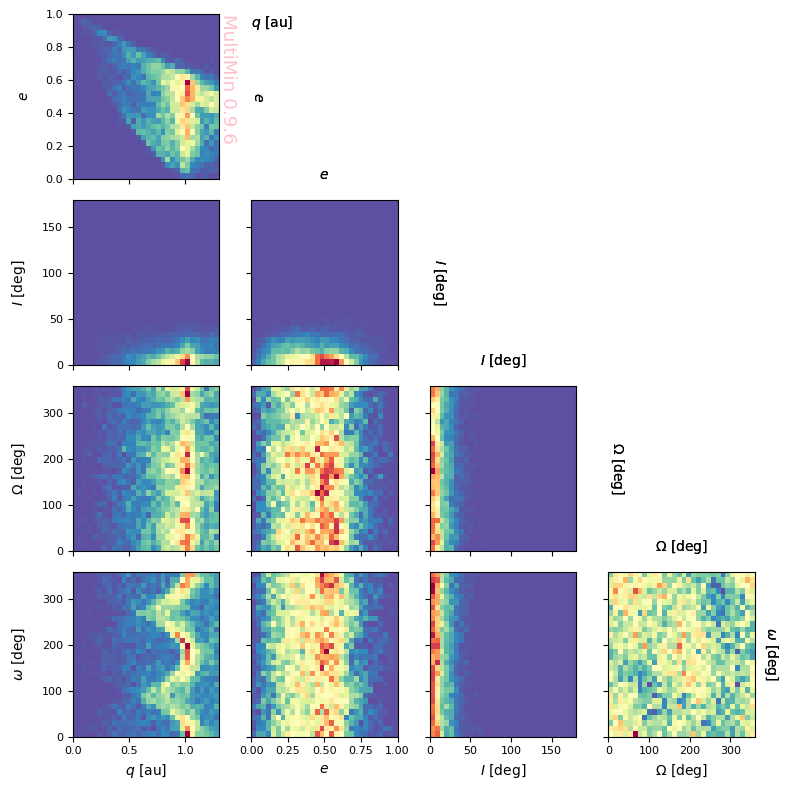

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

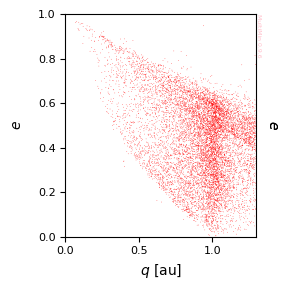

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 97.5108 ms
-log(L)/N = -0.5329991995911952


And check the fit result:

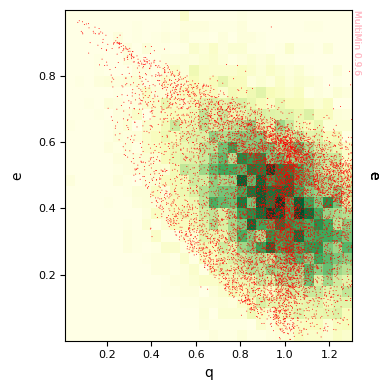

In [9]:
# properties: list of names or dict like DensityPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.97239,0.413777,0.268007,0.190744,-0.43747


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitCMND(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data()
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 20.9354 s
-log(L)/N = -0.7219147389795555


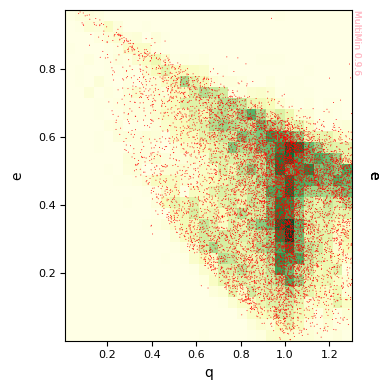

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

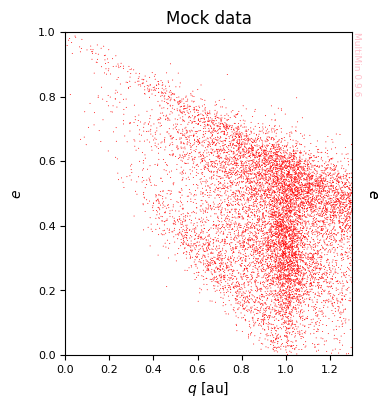

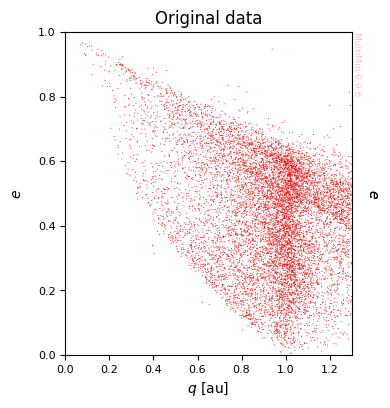

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
5,0.352971,1.107220,0.515820,0.345062,0.115757,-0.826269
3,0.327792,0.960204,0.332081,0.210721,0.135584,-0.531326
1,0.165359,1.003902,0.336284,0.045575,0.153840,-0.071054
2,0.090168,0.717797,0.247774,0.196923,0.149037,-0.946128
4,0.063711,0.748627,0.693315,0.341981,0.132586,-0.987532


In [16]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 1.003902
    mu1_e = 0.336284
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.002077, -0.000498], [-0.000498, 0.023667]]
    Z1 = 0.985582
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.717797
    mu2_e = 0.247774
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.038779, -0.027768], [-0.027768, 0.022212]]
    Z2 = 0.951659
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.960204
    mu3_e = 0.332081
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.044403, -0.01518], [-0.01518, 0.018383]]
    Z3 = 0.942539
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 0.748627
    mu4_e = 0.693315
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.116951, -0.044777], [-0.044777, 0.017579]]
    Z4 = 0.931644
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.10722
    mu5_e = 0.51582
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.119068, -0.033004], [-0.033004, 0.0134]]
    Z5 = 0.711141
    n5 = t

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.4320390013971767


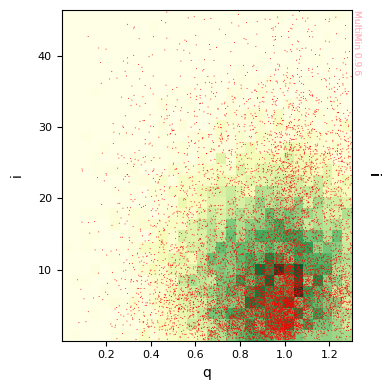

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.262774962619178


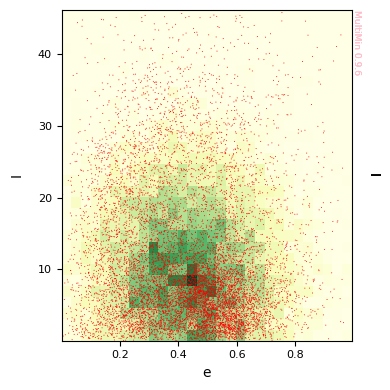

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

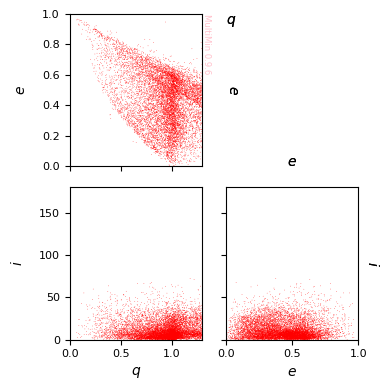

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1, 1.1, 0.72]
	LogL/N: 689.9971273189072
Iter 1:
	Vars: [0.38, 0.5, 0.051, -2.5, -2.2, -7.5, 1, 1.1, 0.67]
	LogL/N: 689.5346128432165
Iter 2:
	Vars: [0.38, 0.5, 0.059, -2.5, -2.2, -7.5, 1, 1.1, 0.7]
	LogL/N: 689.439636427164
Iter 3:
	Vars: [0.38, 0.5, 0.06, -2.5, -2.2, -7.5, 1, 1.1, 0.71]
	LogL/N: 689.4246077800788
Iter 4:
	Vars: [0.38, 0.5, 0.06, -2.5, -2.2, -7.5, 1, 1.1, 0.71]
	LogL/N: 689.4246077770708
Iter 5:
	Vars: [0.38, 0.5, 0.06, -2.5, -2.2, -7.5, 1, 1.1, 0.71]
	LogL/N: 689.4246077886924
Iter 6:
	Vars: [0.38, 0.5, 0.06, -2.5, -2.2, -7.5, 1, 1.1, 0.71]
	LogL/N: 689.424607777611
-log(L)/N = 59.797427749257395


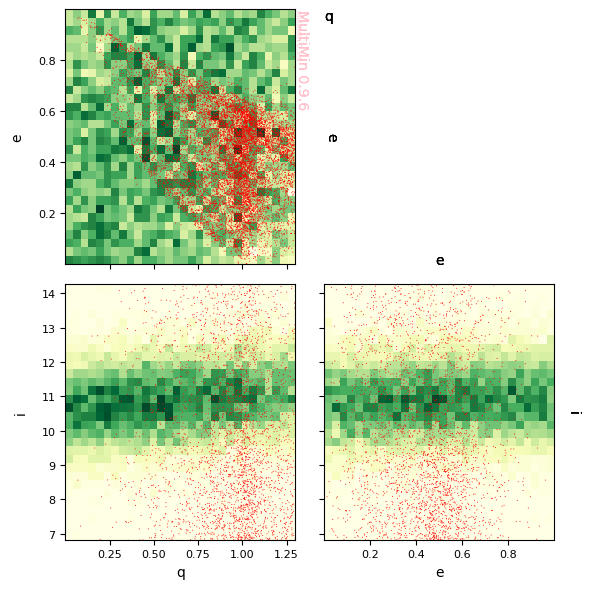

In [21]:
fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.75, 0.42, 0.045, -3.9, -4, -5.2, -0.94, -0.032, -0.12]
	LogL/N: 674.0426271410164
Iter 1:
	Vars: [0.75, 0.42, 0.045, -3.9, -4, -5.2, -0.94, -0.032, -0.12]
	LogL/N: 674.042627161075
Iter 2:
	Vars: [0.75, 0.42, 0.045, -3.9, -4, -5.2, -0.94, -0.032, -0.12]
	LogL/N: 674.042627030747
-log(L)/N = -2.4113193063129312


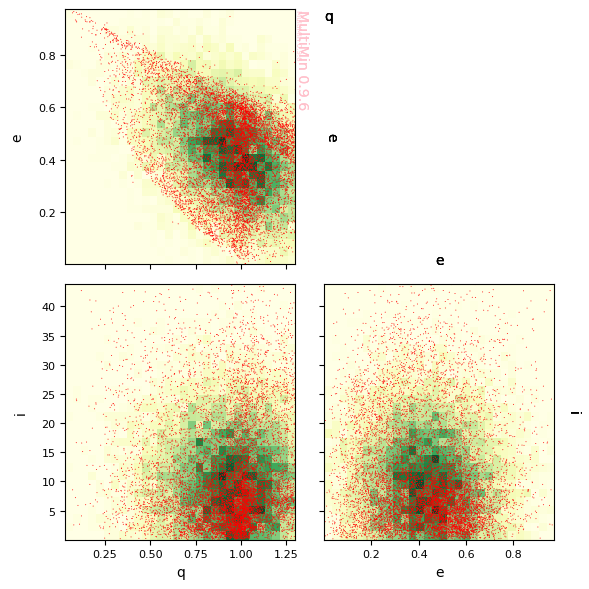

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12]
	LogL/N: 3.044002335139022


Iter 1:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12]
	LogL/N: 3.044004087994047


Iter 2:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12]
	LogL/N: 3.0440070831451354
Iter 3:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, 0.97, 0.42, 8.1, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12, -0.94, -0.032, -0.12]
	LogL/N: 3.0440031694976555


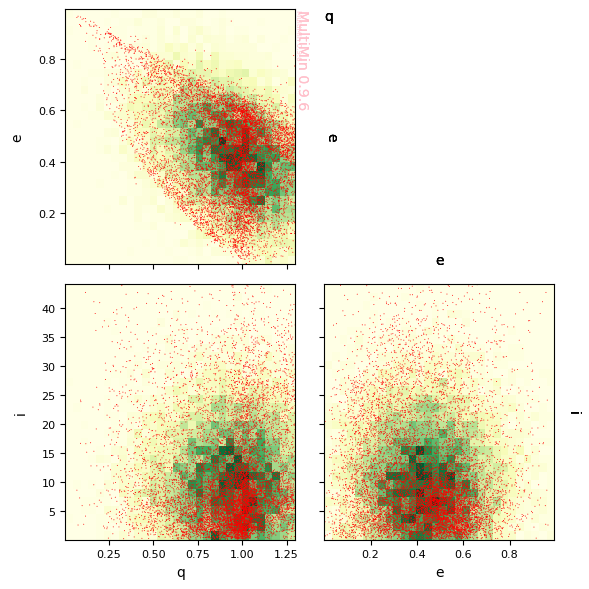

In [23]:
fit_qei = mn.FitCMND(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(advance=True)
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

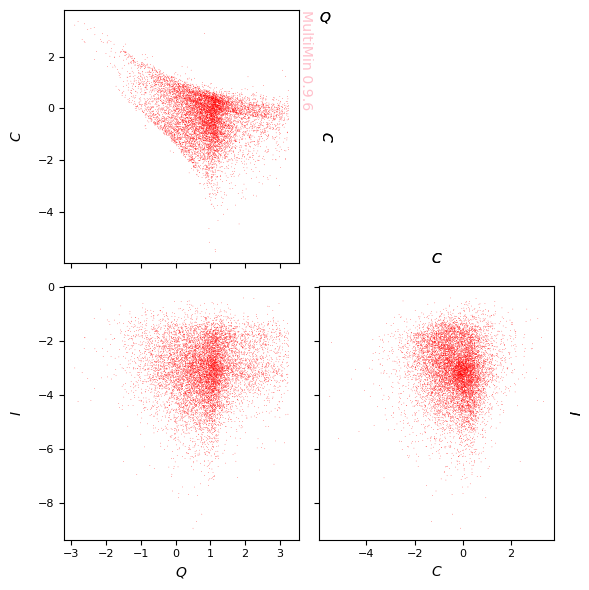

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

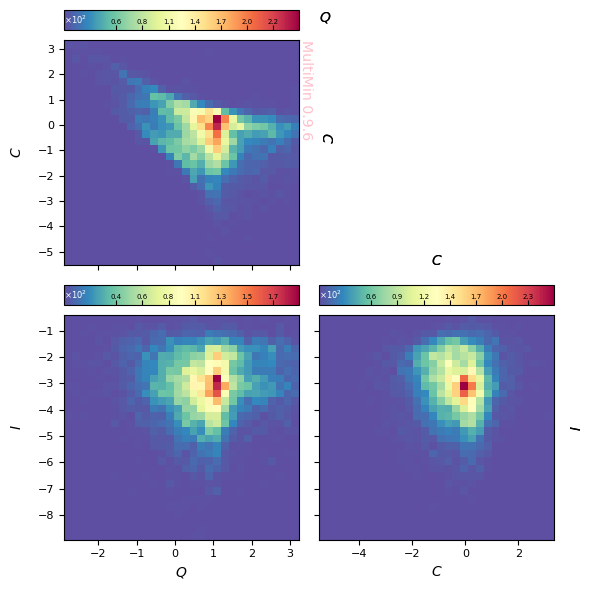

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitCMND(data=udata, ngauss=1)

The fitter holds an initial CMND that will be optimized:

In [28]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.6, -1.9, 1.4, 1.1, 1.1]
	LogL/N: 5.28420714307361
Iter 1:
	Vars: [1.8, 0.53, -2.6, -1.8, -1.8, -1.9, 1.1, 1, 0.82]
	LogL/N: 4.741300552248119
Iter 2:
	Vars: [0.81, -0.37, -3.1, -2.2, -2.2, -2, -0.063, 0.24, 0.51]
	LogL/N: 4.114772877725577
Iter 3:
	Vars: [0.87, -0.35, -3.1, -2.4, -2.3, -2.1, -0.65, 0.065, -0.068]
	LogL/N: 3.976015220860259
Iter 4:
	Vars: [0.87, -0.33, -3.1, -2.4, -2.3, -2.1, -0.67, 0.076, -0.12]
	LogL/N: 3.9750375670402076
Iter 5:
	Vars: [0.86, -0.33, -3.1, -2.4, -2.3, -2.1, -0.67, 0.076, -0.12]
	LogL/N: 3.9748119513464633
Iter 6:
	Vars: [0.86, -0.33, -3.1, -2.4, -2.3, -2.1, -0.67, 0.076, -0.12]
	LogL/N: 3.9748119513464633
Elapsed time since last call: 156.294 ms
-log(L)/N = 3.9748119513464633


Inspect the fitted CMND:

In [30]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8604649329968297, -0.32710963959130757, -3.073507466105959]]
    Standard deviations (σ): [[0.8582628867675851, 0.8744313531395057, 1.064855308369907]]
    Correlation coefficients (ρ): [[-0.32252656232982846, 0.03807600375767062, -0.0592794604382646]]

    Covariant matrices (Σ): 
        [[[0.7366151828026286, -0.2420535975351933, 0.03479864185049544], [-0.2420535975351933, 0.764630191353387, -0.055197646817578244], [0.03479864185049544, -0.055197646817578244, 1.1339168277635698]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8604649329968297, -0.32710963959130757, -3.073507466105959, 0.7366151828026286, -0.2420535975351933, 0.03479864185049544, 0.764630191353387, -0.055197646817578244, 1.1339168277635698]
        With std. and correla

Plot the fit result (fitted sample + data scatter):

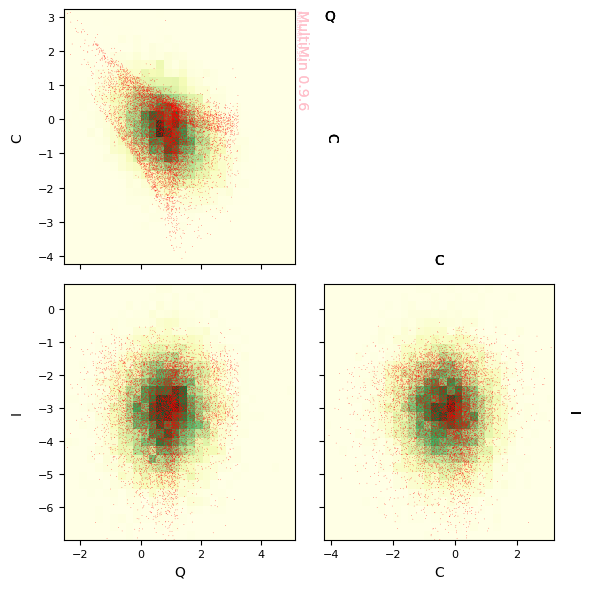

In [31]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8604649329968297, -0.32710963959130757, -3.073507466105959]]
    Standard deviations (σ): [[0.8582628867675851, 0.8744313531395057, 1.064855308369907]]
    Correlation coefficients (ρ): [[-0.32252656232982846, 0.03807600375767062, -0.0592794604382646]]

    Covariant matrices (Σ): 
        [[[0.7366151828026286, -0.2420535975351933, 0.03479864185049544], [-0.2420535975351933, 0.764630191353387, -0.055197646817578244], [0.03479864185049544, -0.055197646817578244, 1.1339168277635698]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8604649329968297, -0.32710963959130757, -3.073507466105959, 0.7366151828026286, -0.2420535975351933, 0.03479864185049544, 0.764630191353387, -0.055197646817578244, 1.1339168277635698]
        With std. and correla

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.48, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.4, 1.2, 1.1, 1.3, 1.3, 0.86]
	LogL/N: 4.9535799463421695


Iter 5:
	Vars: [-1.3, -0.02, 0.42, 0.43, -3.5, 1, -0.62, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.3, -2.1, -0.71, 0.64, 0.0026, 0.23, 0.0085]
	LogL/N: 3.8866723632374107


Iter 9:
	Vars: [-1.4, -0.02, 0.49, 0.45, -3.5, 0.99, -0.62, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.67, -0.085, 0.23, 0.034]
	LogL/N: 3.8844194164755916
Elapsed time since last call: 1.06574 s
-log(L)/N = 3.8844194164755916
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.28322890672033907, 0.7167710932796609]
    Number of variables: 3
    Averages (μ): [[0.49086990544446996, 0.4453666259385665, -3.5026238720444156], [0.9933678521673356, -0.615801764186609, -2.913828791281978]]
    Standard deviations (σ): [[0.8744019363420951, 0.5745776377288152, 1.1744746797048375], [0.8111190998189354, 0.7845830408476461, 0.9714333464504532]]
    Correlation coefficients (ρ): [[-0.8131989252622311, -0.3172689673647978, 0.3238364541543215], [-0.042573437114246326, 0.11311852022389847, 0.017158838506975638]]

    Covariant matrices (Σ): 
        [[[0.7645787462788053, -0.4085607349931364, -0.32582346962975395], [-0.4085607349931364, 0.3301

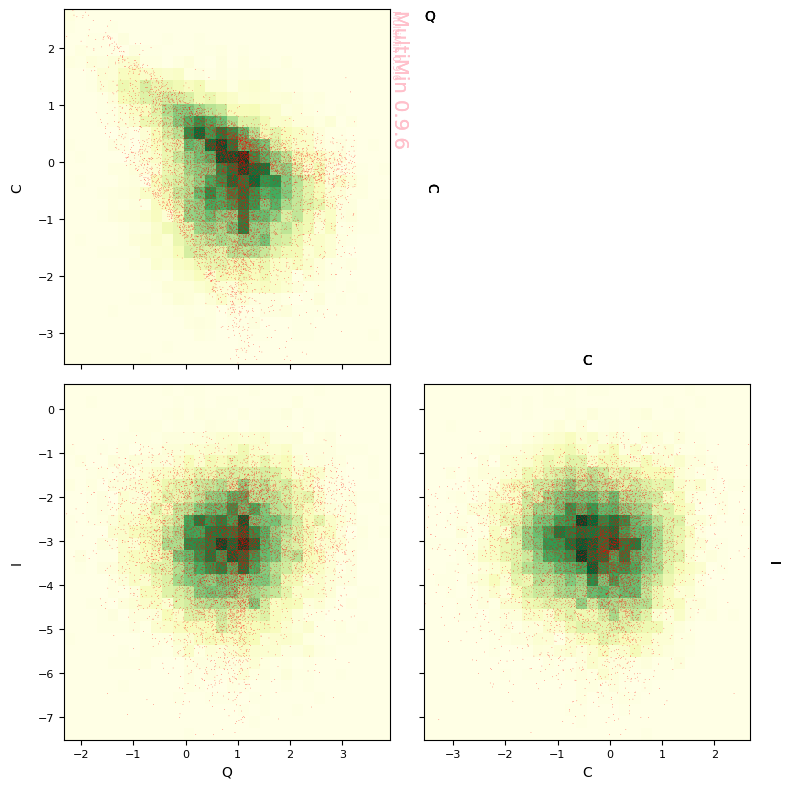

In [34]:
F=mn.FitCMND(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.48, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.4, 1.2, 1.1, 1.3, 1.3, 0.85]
	LogL/N: 4.9541582038996985


Iter 5:
	Vars: [-0.51, 2.2, 0.42, 0.43, -3.5, 1, -0.62, -2.9, -2.4, -2.8, -2, -2.4, -2.5, -2.3, -2.2, -0.71, 0.64, 0.002, 0.23, 0.009]
	LogL/N: 3.8866287799325065


Iter 9:
	Vars: [-0.6, 2.2, 0.49, 0.45, -3.5, 0.99, -0.62, -2.9, -2.3, -2.8, -2, -2.4, -2.5, -2.2, -2.3, -0.66, 0.67, -0.086, 0.23, 0.034]
	LogL/N: 3.8844126591723493
Elapsed time since last call: 1.61443 s
-log(L)/N = 3.8844126591723493
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.28279839583343525, 0.7172016041665648]
    Number of variables: 3
    Averages (μ): [[0.49070549499977695, 0.4457415394373613, -3.502597873733244], [0.9931518503116423, -0.6154636601588053, -2.914065148455927]]
    Standard deviations (σ): [[0.8745952339855182, 0.5747183196014118, 1.174309436859988], [0.8111847019007221, 0.7846115472906667, 0.9716508993689905]]
    Correlation coefficients (ρ): [[-0.8138637475622514, -0.3172403995930573, 0.3238871614006358], [-0.04295356026285102, 0.11299814718869694, 0.017045609712772913]]

    Covariant matrices (Σ): 
        [[[0.7649168233101833, -0.409085278481318, -0.3258203047395568], [-0.409085278481318, 0.33030114688

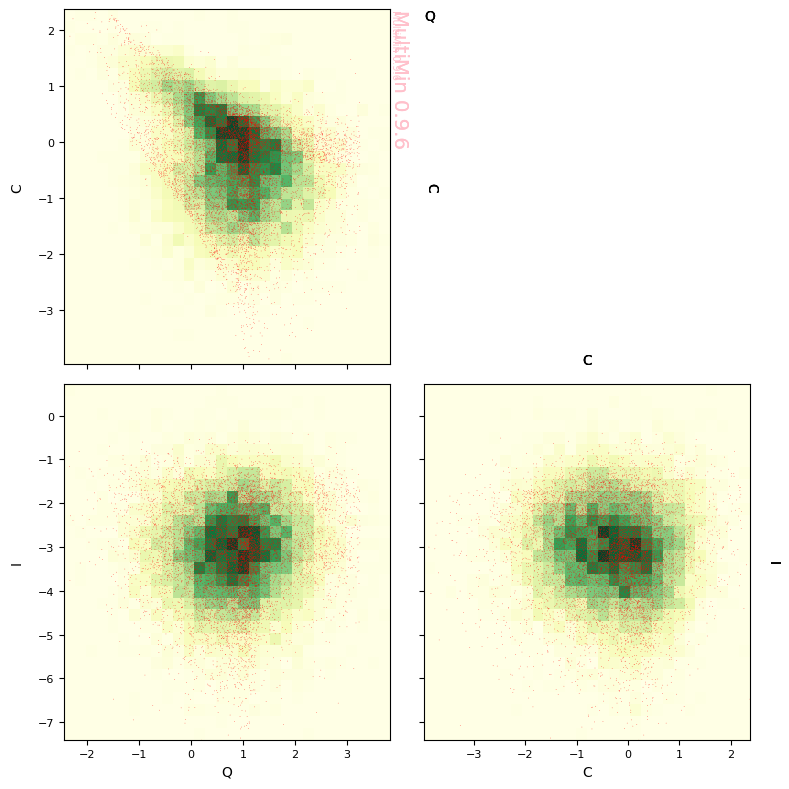

In [35]:
F=mn.FitCMND(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.9, 1.5, -2.2, 2.7, -0.054, -2.2, 1.9, 0.27, -2.9, 1.7, 0.26, -2.3, 0.3, 2.1, -2.2, -1.3, -1.2, -1.3, -1.4, -2.2, -2.4, -2.1, -3.1, -2, -2.3, -2, -2.1, -2.3, -1.3, -2, 2.1, 1.9, 1.3, 2.1, 1.4, 0.74, 0.089, 1.3, 0.84, 1.5, 1.4, 1.1, 0.66, 0.45, 1.1]
	LogL/N: 4.724448710704813


Iter 10:
	Vars: [-2.2, 1.4, 1.1, -0.81, 0.18, 1.6, -1.5, -3.9, 0.96, -0.56, -2.8, 1.1, 0.3, -3.3, 1.4, -0.51, -3.7, -0.067, -0.42, -2.7, -2.5, -2.1, -1.7, -3.3, -2.7, -2.4, -2.3, -3.2, -2.3, -2.4, -2.7, -1.9, -2.5, -2, -2.3, 0.36, 1.3, -0.39, -0.82, 0.5, -0.47, -2.1, 0.36, 0.0073, -0.0058, 1.6, -0.55, -2.5, -0.17, 0.33]
	LogL/N: 3.744554934673203


Iter 14:
	Vars: [-2.2, 0.88, 0.7, -0.97, 0.55, 1.6, -1, -4.2, 0.98, -0.48, -2.9, 1.1, 0.29, -3.3, 1.4, -0.66, -3.5, 0.049, -0.51, -2.7, -2.4, -2.1, -1.6, -3.3, -2.8, -2.4, -2.4, -3.3, -2.2, -2.4, -2.7, -1.9, -2.5, -2, -2.3, 0.0015, 1.4, -0.41, -0.87, 0.55, -0.63, -2.1, 0.38, 0.00034, -0.04, 1.7, -0.59, -2.4, -0.18, 0.34]
	LogL/N: 3.741166971618263
Elapsed time since last call: 9.05915 s
-log(L)/N = 3.741166971618263
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.04193114175025671, 0.2965058979239037, 0.2804229983992632, 0.11556244095321633, 0.26557752097336]
    Number of variables: 3
    Averages (μ): [[1.5667539279945146, -1.0423736161610193, -4.200341313169983], [0.9787369868991495, -0.47850917694030853, -2.8787051306942733], [1.1150334630145686, 0.29026483026359545, -3.294874758318261], [1.4365073761702594, -0.660404379796464, -3.4574838924059805], [0.049259778662827554, -0.5068854095597859, -2.7311439511291455]]
    Standard deviati

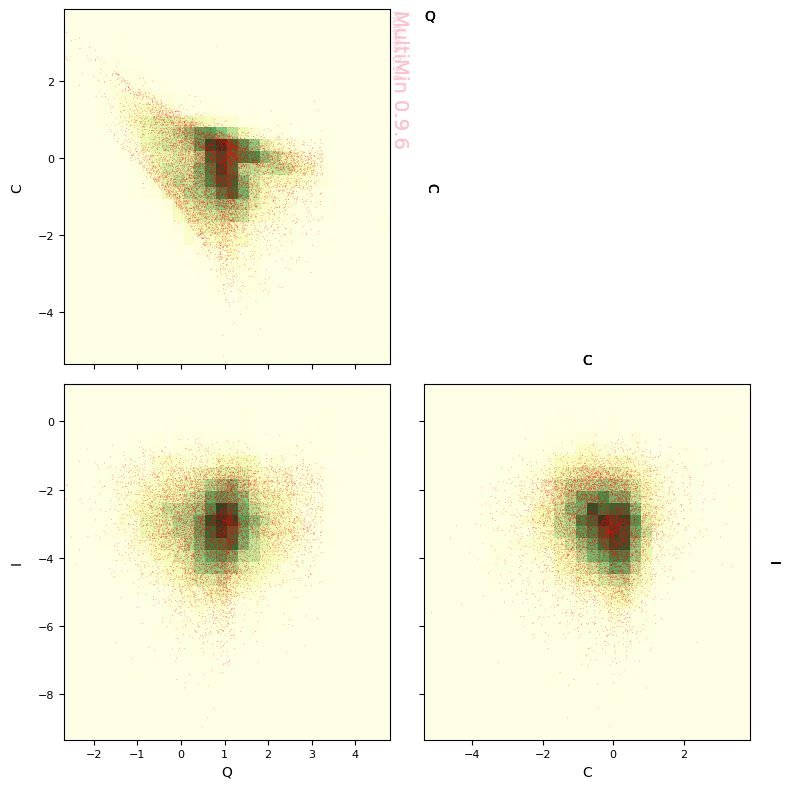

In [36]:
F=mn.FitCMND(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

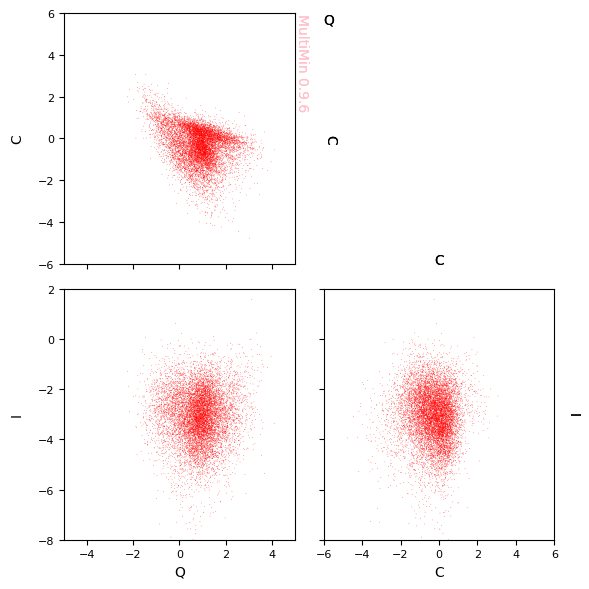

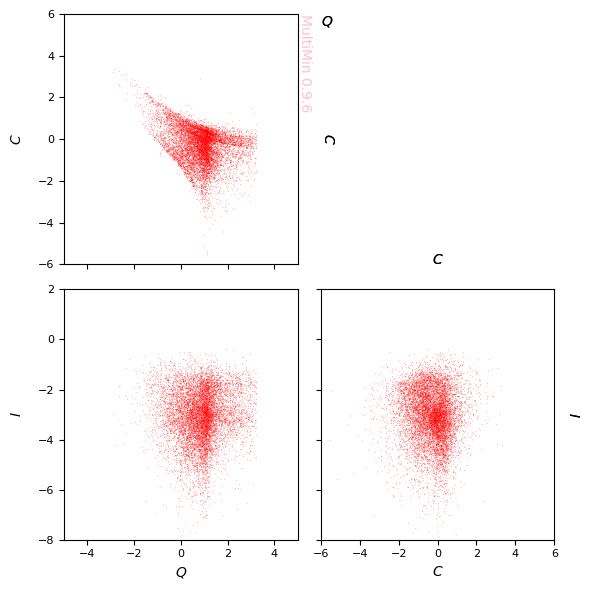

In [37]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

We can also check the original distribution:

In [38]:
scales=[1.35,1.00,180.0]
usample = F.cmnd.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

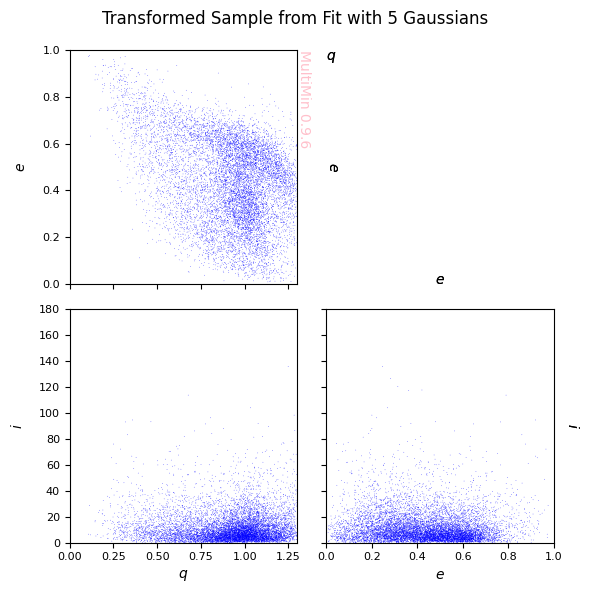

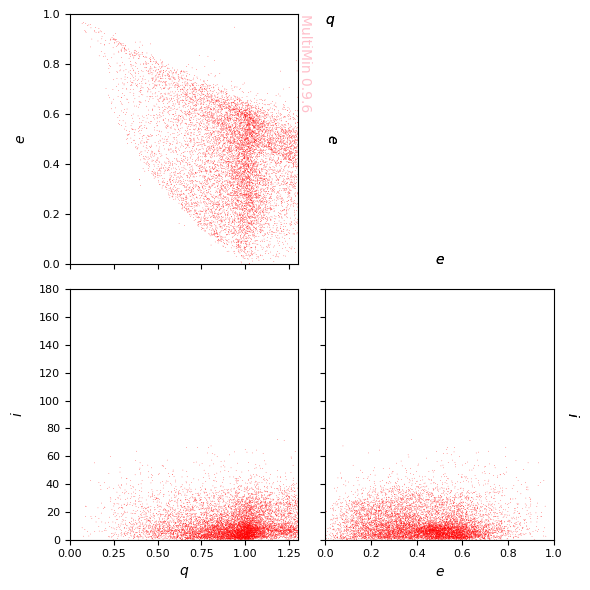

In [39]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [40]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_q = 1.566754
    mu1_e = -1.042374
    mu1_i = -4.200341
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.706713, 0.00068, 0.879739], [0.00068, 1.219792, -0.383586], [0.879739, -0.383586, 2.885589]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_q = 0.978737
    mu2_e = -0.478509
    mu2_i = -2.878705
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.116501, -0.079645, 0.079064], [-0.079645, 0.325258, -0.150527], [0.079064, -0.150527, 0.755183]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_q = 1.115033
    mu3_e = 0.290265
    mu3_i = -3.294875
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.736977, -0.248091, 0.153866], [-0.248091, 0.138122, 6.1e-05], [0.153866, 6.1e-05, 0.917689]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_q = 1.436507
    mu4_e = -0.660404
    mu4_i = -3.457484
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.674726, -0.010596, 0.732398], [-0.010596, 0.410823, -0.235051], [0.732398, -0.235051, 1.630234]]
    n4 = nmd(X, mu4, Sigma4)

    m

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga